In [17]:
# basics
import numpy as np
import pandas as pd
import datetime
import re

# statistics
import statsmodels.api as sm
import statsmodels.formula.api as smf


# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15,12]

# own data wrappers
from imp import reload
import measureclass as mc; reload(mc);
import coronadataclass as cdc; reload(cdc);

np.seterr(divide = 'ignore');


In [18]:
# load data into datawrapper classes
measure_data = mc.COVID19_measures(download_data = False, measure_level = 2, only_first_dates = True, expand_measure_names = True)
jhu_data     = cdc.CoronaData(download_data = False)

# remove and rename countries to match the JFU database and the measures database
measure_data.RemoveCountry('Diamond Princess')
measure_data.RenameCountry('France (metropole)', 'France')
measure_data.RenameCountry('South Korea', 'Korea, South')


In [19]:
# helper functions

def date2vector(implementdate, start = '22/1/20', end = None, shiftdays = 0):
    # generate vector of 0s and 1s when measure is implemented or not
    starttime     = datetime.datetime.strptime(start,         '%d/%m/%y')
    if end is None:
        endtime   = datetime.datetime.today()
    else:
        endtime   = datetime.datetime.strptime(end,           '%d/%m/%y')
    implementtime = datetime.datetime.strptime(implementdate, '%d/%m/%Y')
    
    totaldays   = (endtime       - starttime).days
    measuredays = (implementtime - starttime).days
    
    vec         = np.zeros(totaldays)
    vec[min(measuredays+shiftdays,len(vec)-1):] = 1
    
    return vec


def ConvertDateFormat(date):
    m,d,y = date.split('/')
    return '{:02d}/{:02d}/{:02d}'.format(int(d),int(m),int(y))


def CleanUpMeasureName(measurename):
    # regression model formula can't contain special characters
    return ''.join([mn.capitalize() for mn in measurename.replace(',','').replace('-','').replace('/','').split(' ')])

In [51]:
def GetMeasureIDs(countrylist = None, measure_level = 2, mincount = None, extend_measure_names = False):
    if countrylist is None:
        countrylist = measure_data.countrylist # use ALL countries
    
    measurelist = {}
    
    # get all restrictions from countries
    for country in countrylist:
        country_measures = measure_data.CountryData(country, measure_level = 2, extend_measure_names = extend_measure_names)
        for measurename, initialdata in country_measures.items():
            if not measurename in measurelist.keys():
                measurelist[measurename] = 0
            measurelist[measurename] += 1
    
    if not mincount is None:
        # rebuild dict with restrictions
        measurelist = {k:v for k,v in measurelist.items() if v >= mincount}

    return measurelist


def SmoothTrajectories3(traj):
    if len(traj) > 3:
        newtraj       = np.zeros(len(traj))
        newtraj[0]    = (             2 * traj[0]    + traj[1] )/3.
        newtraj[1:-1] = (traj[0:-2] + 2 * traj[1:-1] + traj[2:])/4.
        newtraj[-1]   = (traj[-2]   + 2 * traj[-1]             )/3.
        return newtraj
    else:
        return traj


def GetCountryTrajectories(countrylist = None, data = 'Confirmed', startcases = None, maxlen = None, smooth = False):
    if countrylist is None:
        countrylist = jhu_data.countrylist
    
    trajectories = {}
    for country in [c for c in countrylist if c in jhu_data.countrylist]:
        ctraj = np.array(jhu_data.CountryData(country)[data], dtype = np.float)
        starttraj = 0
        if not startcases is None:
            starttraj = np.argmax(ctraj >= startcases)
            ctraj = ctraj[starttraj:]
            if not maxlen is None:
                ctraj = ctraj[:min(maxlen,len(ctraj))]
        trajectories[country] = {}
        if smooth:
            ctraj = SmoothTrajectories3(ctraj)
        trajectories[country]['traj'] = ctraj
        trajectories[country]['startdate'] = ConvertDateFormat(jhu_data.CountryData(country)['Date'][starttraj])
    
    return trajectories

        
def GetRegressionDF(countrylist = None, measure_level = 2, shiftdays = 0, verbose = False, maxlen = None, smooth = None):
    # construct pd.DataFrame used for regression
    
    # get trajectories and measure list for all countries in 'countrylist'
    trajectories         = GetCountryTrajectories(countrylist = countrylist, data = 'Confirmed', startcases = 30, maxlen = maxlen, smooth = smooth)
    measureIDs           = measure_data.MeasureList(countrylist = countrylist, measure_level = 2, mincount = 5)
    cleaned_measurelist  = {CleanUpMeasureName(mn):count for mn,count in measureIDs.items()}
    regressionDF         = None
    
    if verbose:
        print(measureIDs)
    
    for country in trajectories.keys():
        if country in measure_data.countrylist:

            # ********************************************
            # change observable to regress here:
            observable                  = np.diff(np.log(trajectories[country]['traj']))
            obslen                      = len(observable)
            # ********************************************
            
            DF_country = measure_data.ImplementationTable(country           = country,
                                                        measure_level     = 2,
                                                        startdate         = trajectories[country]['startdate'],
                                                        shiftdays         = shiftdays,
                                                        maxlen            = obslen,
                                                        clean_measurename = True)
            
            for measurename in DF_country.columns:
                if measurename not in measureIDs.keys():
                    DF_country.drop(labels = measurename, axis = 'columns')
            
            DF_country['Country']    = country
            DF_country['Observable'] = observable

            
            if not (np.isnan(DF_country['Observable']).any() or np.isinf(DF_country['Observable']).any()):

                if regressionDF is None:
                    regressionDF = DF_country
                else:
                    regressionDF = pd.concat([regressionDF,DF_country], ignore_index = True, sort = False)
    
    # not implemented measures should be NaN values, set them to 0
    regressionDF.fillna(0, inplace = True)
    
    return regressionDF, cleaned_measurelist



def GetCountryMasks(regrDF):
    countrylist = list(regrDF['Country'].unique())
    maskdict = {}
    for country in countrylist:
        mask = list(regrDF['Country'] == country)
        maskdict[country] = mask
    return maskdict


In [54]:
# set up of all models
# for cross-validation by excluding each country

maxshift       = 10
regrDF         = []
model_excludeC = []
model_singleC  = []
allresults     = None

for shiftdays in range(0, maxshift + 1):
    print('shiftdays = {}'.format(shiftdays))
    tmp, measurelist = GetRegressionDF(countrylist = measure_data.countrylist, shiftdays = shiftdays, maxlen = 40, smooth = True)
    regrDF.append(tmp)

    countrylist = tmp['Country'].unique()
    formula     = 'Observable ~ C(Country) + ' + ' + '.join(measurelist)
    
    model_excludeC.append(dict())
    model_singleC.append(dict())
    
    for country in countrylist:
        DF_excludeC = regrDF[shiftdays][regrDF[shiftdays]['Country'] != country]
        DF_singleC  = regrDF[shiftdays][regrDF[shiftdays]['Country'] == country]
        model_excludeC[shiftdays][country] = smf.ols(formula = formula, data = DF_excludeC, drop_cols = 'Time')
        model_singleC [shiftdays][country] = smf.ols(formula = formula, data = DF_singleC,  drop_cols = 'Time')
    


shiftdays = 0
shiftdays = 1
shiftdays = 2
shiftdays = 3
shiftdays = 4
shiftdays = 5
shiftdays = 6
shiftdays = 7
shiftdays = 8
shiftdays = 9
shiftdays = 10


In [61]:
#llres = None
for shiftdays in np.arange(maxshift + 1):
    
    print('shiftdays = {}'.format(shiftdays))
    
    for alpha in np.power(10,np.linspace(-4, -2, num = 21)):
        print('   alpha = {:.6f}'.format(alpha))
        for country in countrylist:
            results = model_excludeC[shiftdays][country].fit_regularized(alpha = alpha, L1_wt = 1)
            
            result_dict = {}
            result_dict['shiftdays']        = shiftdays
            result_dict['alpha']            = alpha
            result_dict['excludeC']         = country
            
            param_excludeC                  = np.array(results.params)
            param_singleC                   = np.concatenate([np.array([param_excludeC[0]]),param_excludeC[len(countrylist)-1:]])

            result_dict['Loglike Training'] = model_excludeC[shiftdays][country].loglike(results.params)
            result_dict['Loglike Test']     = model_singleC[shiftdays][country].loglike(param_singleC)

            result_dict.update({k:v for k,v in results.params.items()})
            
            if allresults is None:
                allresults = pd.DataFrame({k:np.array([v]) for k,v in result_dict.items()})
            else:
                allresults = allresults.append(result_dict, ignore_index = True)


shiftdays = 0
   alpha = 0.000100
   alpha = 0.000126
   alpha = 0.000158
   alpha = 0.000200
   alpha = 0.000251
   alpha = 0.000316
   alpha = 0.000398
   alpha = 0.000501
   alpha = 0.000631
   alpha = 0.000794
   alpha = 0.001000
   alpha = 0.001259
   alpha = 0.001585
   alpha = 0.001995
   alpha = 0.002512
   alpha = 0.003162
   alpha = 0.003981
   alpha = 0.005012
   alpha = 0.006310
   alpha = 0.007943
   alpha = 0.010000
shiftdays = 1
   alpha = 0.000100
   alpha = 0.000126
   alpha = 0.000158
   alpha = 0.000200
   alpha = 0.000251
   alpha = 0.000316
   alpha = 0.000398
   alpha = 0.000501
   alpha = 0.000631
   alpha = 0.000794
   alpha = 0.001000
   alpha = 0.001259
   alpha = 0.001585
   alpha = 0.001995
   alpha = 0.002512
   alpha = 0.003162
   alpha = 0.003981
   alpha = 0.005012
   alpha = 0.006310
   alpha = 0.007943
   alpha = 0.010000
shiftdays = 2
   alpha = 0.000100
   alpha = 0.000126
   alpha = 0.000158
   alpha = 0.000200
   alpha = 0.000251
   alpha = 0.00031

In [ ]:
# for shiftdays in np.arange(maxshift + 1):
    
    print('shiftdays = {}'.format(shiftdays))
    
    for alpha in np.power(10,np.linspace(-5, -4, num = 10, endpoint = False)):
        print('   alpha = {:.6f}'.format(alpha))
        for country in countrylist:
            results = model_excludeC[shiftdays][country].fit_regularized(alpha = alpha, L1_wt = 1)
            
            result_dict = {}
            result_dict['shiftdays']        = shiftdays
            result_dict['alpha']            = alpha
            result_dict['excludeC']         = country
            
            param_excludeC                  = np.array(results.params)
            param_singleC                   = np.concatenate([np.array([param_excludeC[0]]),param_excludeC[len(countrylist)-1:]])

            result_dict['Loglike Training'] = model_excludeC[shiftdays][country].loglike(results.params)
            result_dict['Loglike Test']     = model_singleC[shiftdays][country].loglike(param_singleC)

            result_dict.update({k:v for k,v in results.params.items()})
            
            if allresults is None:
                allresults = pd.DataFrame({k:np.array([v]) for k,v in result_dict.items()})
            else:
                allresults = allresults.append(result_dict, ignore_index = True)


In [70]:
allresults.to_csv('results_Xval_country.csv')

In [90]:
allresults = pd.read_csv('results_Xval_country.csv')

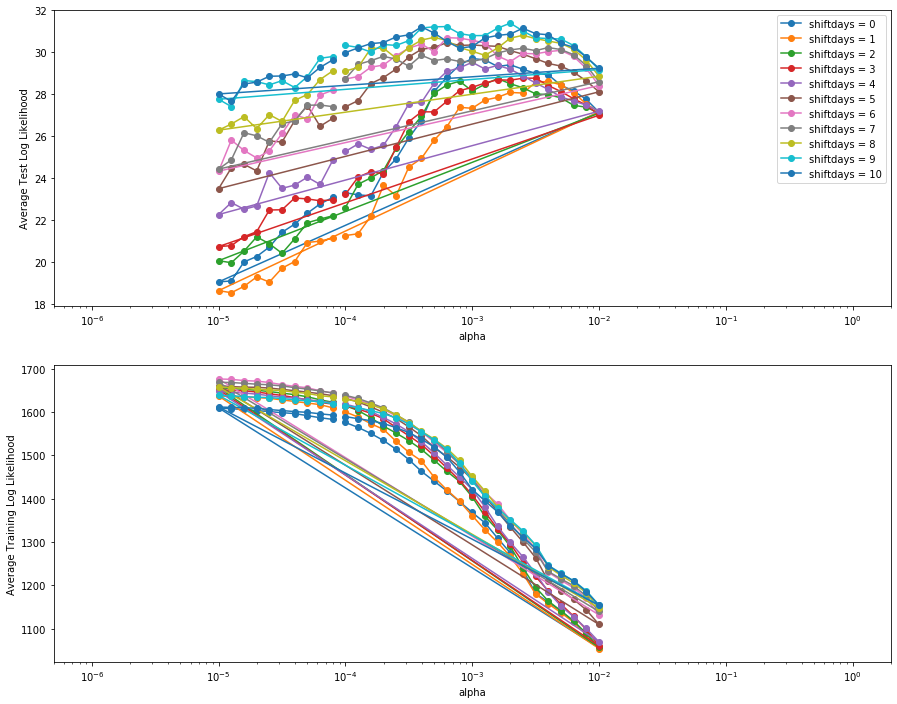

In [92]:
colornames = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]

shiftdaylist = allresults['shiftdays'].unique()
alphalist    = allresults['alpha'].unique()

fig,ax = plt.subplots(2,1)

for shiftdays in shiftdaylist:
    lltest_list = []
    lltrain_list = []
    for alpha in alphalist:
        lltest_list.append(np.mean(allresults[(allresults['shiftdays']==shiftdays) & (allresults['alpha'] == alpha)]['Loglike Test']))
        lltrain_list.append(np.mean(allresults[(allresults['shiftdays']==shiftdays) & (allresults['alpha'] == alpha)]['Loglike Training']))
    ax[0].plot(alphalist,lltest_list, label = 'shiftdays = {}'.format(shiftdays), marker = 'o')
    ax[1].plot(alphalist,lltrain_list, label = 'shiftdays = {}'.format(shiftdays), marker = 'o')
    pd.DataFrame({'alpha':alphalist,'loglike train':lltrain_list,'loglike test':lltest_list}).to_csv('average_LogLikelihood_Xval_country_sd{}.csv'.format(shiftdays))
ax[0].legend()
ax[0].set_xscale('log')
ax[0].set_xlim([1e-6/2,2e0])
ax[0].set_xlabel(r'alpha')
ax[0].set_ylabel('Average Test Log Likelihood')
ax[1].set_xscale('log')
ax[1].set_xlim([1e-6/2,2e0])
ax[1].set_xlabel(r'alpha')
ax[1].set_ylabel('Average Training Log Likelihood')
plt.savefig('loglikelihood_Xval_country.pdf')




In [86]:
# cross-validation with random sampling

maxshift     = 10
regrDF       = []
model_train  = []
model_test   = []

regrDF_train = []
regrDF_test  = []

allresults_rndXv     = None



for shiftdays in range(0, maxshift + 1):
    print('shiftdays = {}'.format(shiftdays))
    tmp, measurelist = GetRegressionDF(countrylist = measure_data.countrylist, shiftdays = shiftdays, maxlen = 40, smooth = True)
    regrDF.append(tmp)

    countrylist = tmp['Country'].unique()
    formula     = 'Observable ~ C(Country) + ' + ' + '.join(measurelist)
    
    # generate random list of samples for 10x cross validation
    xval_count = 10
    samples = np.random.randint(xval_count, size = len(regrDF[shiftdays]))

    regrDF_train.append([])
    regrDF_test.append([])
    model_train.append([])
    model_test.append([])
    
    for i in range(xval_count):
        regrDF_train[shiftdays].append(regrDF[shiftdays][samples != i])
        regrDF_test [shiftdays].append(regrDF[shiftdays][samples == i])
        
        model_train [shiftdays].append(smf.ols(formula = formula, data = regrDF_train[shiftdays][i]))
        model_test  [shiftdays].append(smf.ols(formula = formula, data = regrDF_test[shiftdays][i]))


shiftdays = 0
shiftdays = 1
shiftdays = 2
shiftdays = 3
shiftdays = 4
shiftdays = 5
shiftdays = 6
shiftdays = 7
shiftdays = 8
shiftdays = 9
shiftdays = 10


In [116]:
for shiftdays in np.arange(maxshift + 1):
    
    print('shiftdays = {}'.format(shiftdays))
    
    for alpha in np.power(10,np.linspace(-6, -2, num = 5, endpoint = True)):
        print('   alpha = {:.6f}'.format(alpha))
        for i in range(xval_count):
            results = model_train[shiftdays][i].fit_regularized(alpha = alpha, L1_wt = 1)
            
            result_dict = {}
            result_dict['shiftdays']        = shiftdays
            result_dict['alpha']            = alpha
            result_dict['iteration']        = i
            
            test_params = []
            for paramname in model_test[shiftdays][i].exog_names:
                if paramname in results.params.keys():
                    test_params.append(results.params[paramname])
                else:
                    test_params.append(0)
            result_dict['Loglike Training'] = model_train[shiftdays][i].loglike(results.params)
            result_dict['Loglike Test']     = model_test[shiftdays][i].loglike(np.array(test_params))

            result_dict.update({k:v for k,v in results.params.items()})
            
            if allresults_rndXv is None:
                allresults_rndXv = pd.DataFrame({k:np.array([v]) for k,v in result_dict.items()})
            else:
                allresults_rndXv = allresults_rndXv.append(result_dict, ignore_index = True)


shiftdays = 0
   alpha = 0.000001
   alpha = 0.000010
   alpha = 0.000100
   alpha = 0.001000
   alpha = 0.010000
shiftdays = 1
   alpha = 0.000001
   alpha = 0.000010
   alpha = 0.000100
   alpha = 0.001000
   alpha = 0.010000
shiftdays = 2
   alpha = 0.000001
   alpha = 0.000010
   alpha = 0.000100
   alpha = 0.001000
   alpha = 0.010000
shiftdays = 3
   alpha = 0.000001
   alpha = 0.000010
   alpha = 0.000100
   alpha = 0.001000
   alpha = 0.010000
shiftdays = 4
   alpha = 0.000001
   alpha = 0.000010
   alpha = 0.000100
   alpha = 0.001000
   alpha = 0.010000
shiftdays = 5
   alpha = 0.000001
   alpha = 0.000010
   alpha = 0.000100
   alpha = 0.001000
   alpha = 0.010000
shiftdays = 6
   alpha = 0.000001
   alpha = 0.000010
   alpha = 0.000100
   alpha = 0.001000
   alpha = 0.010000
shiftdays = 7
   alpha = 0.000001
   alpha = 0.000010
   alpha = 0.000100
   alpha = 0.001000
   alpha = 0.010000
shiftdays = 8
   alpha = 0.000001
   alpha = 0.000010
   alpha = 0.000100
   alpha = 0.0

In [145]:
for shiftdays in np.arange(maxshift + 1):
    
    print('shiftdays = {}'.format(shiftdays))
    
    for alpha in np.power(10,np.linspace(-5, -3, num = 10, endpoint = False)):
        print('   alpha = {:.6f}'.format(alpha))
        if alpha != 1e-5 and alpha != 1e-4:
            for i in range(xval_count):
                results = model_train[shiftdays][i].fit_regularized(alpha = alpha, L1_wt = 1)

                result_dict = {}
                result_dict['shiftdays']        = shiftdays
                result_dict['alpha']            = alpha
                result_dict['iteration']        = i

                test_params = []
                for paramname in model_test[shiftdays][i].exog_names:
                    if paramname in results.params.keys():
                        test_params.append(results.params[paramname])
                    else:
                        test_params.append(0)
                result_dict['Loglike Training'] = model_train[shiftdays][i].loglike(results.params)
                result_dict['Loglike Test']     = model_test[shiftdays][i].loglike(np.array(test_params))

                result_dict.update({k:v for k,v in results.params.items()})

                if allresults_rndXv is None:
                    allresults_rndXv = pd.DataFrame({k:np.array([v]) for k,v in result_dict.items()})
                else:
                    allresults_rndXv = allresults_rndXv.append(result_dict, ignore_index = True)


shiftdays = 0
   alpha = 0.000010
   alpha = 0.000016
   alpha = 0.000025
   alpha = 0.000040
   alpha = 0.000063
   alpha = 0.000100
   alpha = 0.000158
   alpha = 0.000251
   alpha = 0.000398
   alpha = 0.000631
shiftdays = 1
   alpha = 0.000010
   alpha = 0.000016
   alpha = 0.000025
   alpha = 0.000040
   alpha = 0.000063
   alpha = 0.000100
   alpha = 0.000158
   alpha = 0.000251
   alpha = 0.000398
   alpha = 0.000631
shiftdays = 2
   alpha = 0.000010
   alpha = 0.000016
   alpha = 0.000025
   alpha = 0.000040
   alpha = 0.000063
   alpha = 0.000100
   alpha = 0.000158
   alpha = 0.000251
   alpha = 0.000398
   alpha = 0.000631
shiftdays = 3
   alpha = 0.000010
   alpha = 0.000016
   alpha = 0.000025
   alpha = 0.000040
   alpha = 0.000063
   alpha = 0.000100
   alpha = 0.000158
   alpha = 0.000251
   alpha = 0.000398
   alpha = 0.000631
shiftdays = 4
   alpha = 0.000010
   alpha = 0.000016
   alpha = 0.000025
   alpha = 0.000040
   alpha = 0.000063
   alpha = 0.000100
   alpha =

In [146]:
allresults_rndXv.to_csv('results_Xval_rnd10.csv')

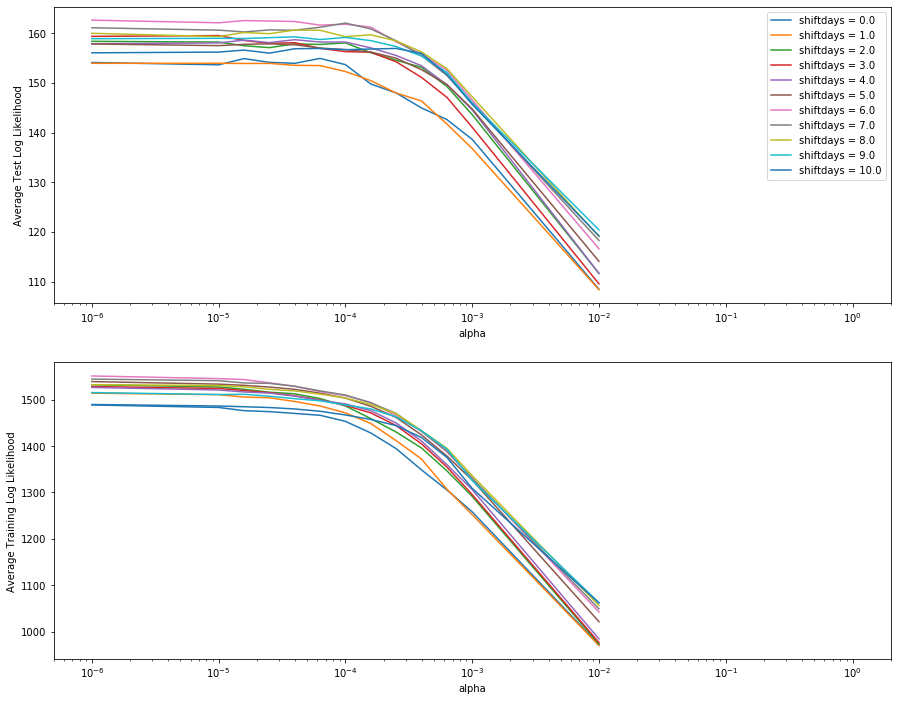

In [150]:
shiftdaylist = allresults_rndXv['shiftdays'].unique()
alphalist    = allresults_rndXv['alpha'].unique()

fig,ax = plt.subplots(2,1)
avg_loglike_rnd10 = None
for shiftdays in shiftdaylist:
    lltest_list = []
    lltrain_list = []
    for alpha in alphalist:
        lltest_list.append(np.mean(allresults_rndXv[(allresults_rndXv['shiftdays']==shiftdays) & (allresults_rndXv['alpha'] == alpha)]['Loglike Test']))
        lltrain_list.append(np.mean(allresults_rndXv[(allresults_rndXv['shiftdays']==shiftdays) & (allresults_rndXv['alpha'] == alpha)]['Loglike Training']))
    
    resdict = {'shiftdays': shiftdays * np.ones(len(alphalist),dtype=int), 'alpha':np.array(alphalist),'loglike train':np.array(lltrain_list),'loglike test':np.array(lltest_list)}
    if avg_loglike_rnd10 is None:
        avg_loglike_rnd10 = pd.DataFrame(resdict)
    else:
        avg_loglike_rnd10 = avg_loglike_rnd10.append(pd.DataFrame(resdict), ignore_index = True)

        
#print(avg_loglike_rnd10)
avg_loglike_rnd10.sort_values(by = 'alpha', inplace = True)
for shiftdays in shiftdaylist:
    ax[0].plot(avg_loglike_rnd10[avg_loglike_rnd10['shiftdays']==shiftdays]['alpha'], avg_loglike_rnd10[avg_loglike_rnd10['shiftdays']==shiftdays]['loglike test'], label = 'shiftdays = {}'.format(shiftdays))
    ax[1].plot(avg_loglike_rnd10[avg_loglike_rnd10['shiftdays']==shiftdays]['alpha'], avg_loglike_rnd10[avg_loglike_rnd10['shiftdays']==shiftdays]['loglike train'], label = 'shiftdays = {}'.format(shiftdays))


ax[0].legend()
ax[0].set_xscale('log')
ax[0].set_xlim([1e-6/2,2e0])
ax[0].set_xlabel(r'alpha')
ax[0].set_ylabel('Average Test Log Likelihood')
ax[1].set_xscale('log')
ax[1].set_xlim([1e-6/2,2e0])
ax[1].set_xlabel(r'alpha')
ax[1].set_ylabel('Average Training Log Likelihood')
plt.savefig('loglikelihood_Xval_rnd10.pdf')


In [102]:
# use parameters from country-wise cross validation
# shiftdays = 9, alpha = 2e-3
model_final7   = smf.ols(formula = formula, data = regrDF[7])
results_final7 = model_final7.fit_regularized(alpha = 2e-3, L1_wt = 1)

model_final8   = smf.ols(formula = formula, data = regrDF[8])
results_final8 = model_final8.fit_regularized(alpha = 2e-3, L1_wt = 1)

model_final9   = smf.ols(formula = formula, data = regrDF[9])
results_final9 = model_final9.fit_regularized(alpha = 2e-3, L1_wt = 1)

In [103]:
colornames = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]

countrylist = [paramname.split('.')[1].split(']')[0] for paramname in results_final.params.index if paramname[:3] == 'C(C']

# collect measure names for labels
ml = GetMeasureIDs(measure_level = 2,mincount = 5, extend_measure_names=True)
measure_level_dict = {}
for mn in ml.keys():
    l1,l2 = mn.split(' - ')
    if not l1 in measure_level_dict.keys():
        measure_level_dict[l1] = {}
    measure_level_dict[l1][l2] = CleanUpMeasureName(l2)

intercept7 = results_final7.params['Intercept']
intercept8 = results_final8.params['Intercept']
intercept9 = results_final9.params['Intercept']


/home/lukas/projects/corona/programs/measureclass.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countrydata['Measure_L{:d}'.format(ml)] = countrydata['Measure_L{:d}'.format(ml)].fillna(countrydata['Measure_L{:d}'.format(ml-1)])
/home/lukas/projects/corona/programs/measureclass.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countrydata['MN'] = countrydata[['Measure_L{:d}'.format(ml+1) for ml in range(measure_level)]].agg(' - '.join, axis = 1)


In [98]:
print(countrylist)
print(measure_level_dict)
print(intercept)

['Austria', 'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Canada', 'Croatia', 'Denmark', 'Ecuador', 'El Salvador', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Italy', 'Japan', 'Kazakhstan', 'Korea, South', 'Kosovo', 'Kuwait', 'Liechtenstein', 'Lithuania', 'Malaysia', 'Mexico', 'Montenegro', 'Netherlands', 'New Zealand', 'North Macedonia', 'Norway', 'Portugal', 'Romania', 'Serbia', 'Singapore', 'Slovakia', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'United Kingdom']
{'Case identification, contact tracing and related measures': {'Enhance the system': 'EnhanceTheSystem', 'Specific health channel for travellers': 'SpecificHealthChannelForTravellers', 'Airport health check': 'AirportHealthCheck', 'Border health check': 'BorderHealthCheck', 'Isolation of cases': 'IsolationOfCases', 'Quarantine': 'Quarantine', 'Research and test of contacts': 'ResearchAndTestOfContacts', 'Research and test of suspected cases': 'ResearchAnd

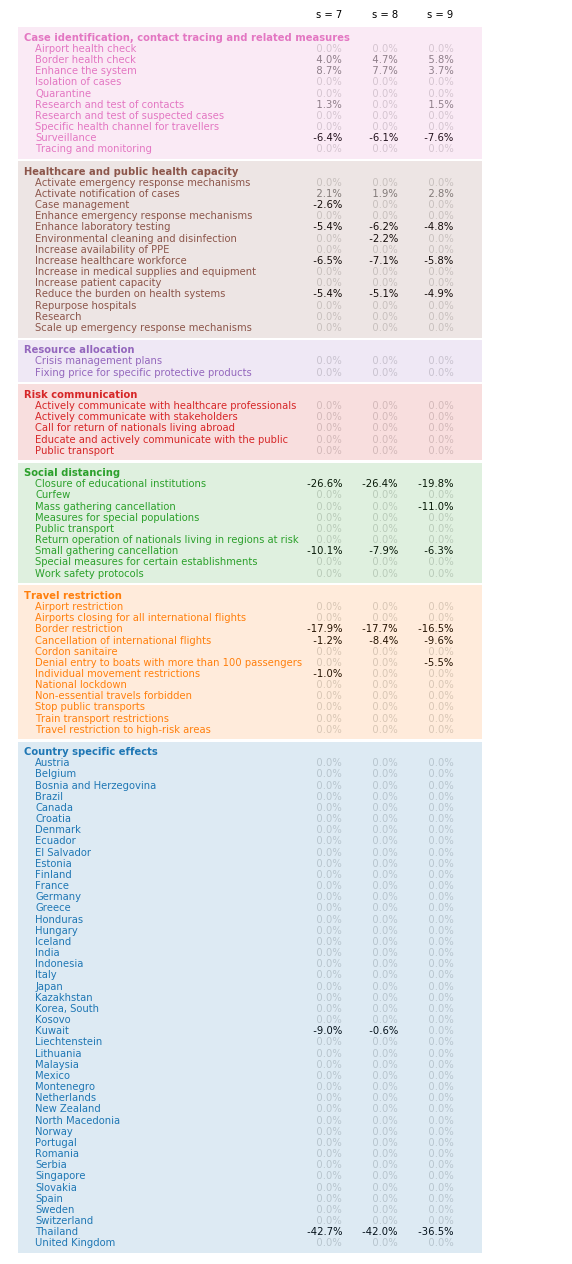

In [109]:
def significanceColor(beta):
    if beta > 0:    return 'gray'
    elif beta == 0: return 'lightgray'
    else:           return 'black'

    
l1list = list(measure_level_dict.keys())
l1list.sort()

fig,ax = plt.subplots(figsize = (10,23))

i = 0
groupcolor = 0

label_x = 1
label_x_header = .6
value_x  = 12
value_dx = 2
boxalpha = .15
ax.annotate('Country specific effects',[label_x_header, len(countrylist)], c = colornames[groupcolor], weight = 'bold' )

background = plt.Rectangle([label_x - .6, i - .65], value_x + 4.6, len(countrylist) + 1.8, fill = True, fc = colornames[groupcolor], alpha = boxalpha, zorder = 10)
ax.add_patch(background)


for country in countrylist[::-1]:
    ax.annotate(country, [label_x, i], c= colornames[groupcolor])
    beta_val7 = results_final7.params['C(Country)[T.{}]'.format(country)] / intercept7
    beta_val8 = results_final8.params['C(Country)[T.{}]'.format(country)] / intercept8
    beta_val9 = results_final9.params['C(Country)[T.{}]'.format(country)] / intercept9
    c7 = significanceColor(beta_val7)
    c8 = significanceColor(beta_val8)
    c9 = significanceColor(beta_val9)
    ax.annotate('{:6.1f}%'.format(beta_val7*100),[value_x + 0 * value_dx, i], c = c7, ha = 'right')
    ax.annotate('{:6.1f}%'.format(beta_val8*100),[value_x + 1 * value_dx, i], c = c8, ha = 'right')
    ax.annotate('{:6.1f}%'.format(beta_val9*100),[value_x + 2 * value_dx, i], c = c9, ha = 'right')
    i += 1

groupcolor += 1

i+=2 

for l1 in l1list[::-1]:
    ax.annotate(l1,[label_x_header, i + len(measure_level_dict[l1])], c = colornames[groupcolor], weight = 'bold')
    l2list = list(measure_level_dict[l1].keys())
    l2list.sort()
    
    background = plt.Rectangle([label_x - .6, i - .65], value_x + 4.6, len(measure_level_dict[l1]) + 1.8, fill = True, fc = colornames[groupcolor], alpha = boxalpha, zorder = 10)
    ax.add_patch(background)
    
    for l2 in l2list[::-1]:
        ax.annotate(l2,[label_x,i],c = colornames[groupcolor])
        beta_val7 = results_final7.params[measure_level_dict[l1][l2]]/intercept7
        beta_val8 = results_final8.params[measure_level_dict[l1][l2]]/intercept8
        beta_val9 = results_final9.params[measure_level_dict[l1][l2]]/intercept9
        c7 = significanceColor(beta_val7)
        c8 = significanceColor(beta_val8)
        c9 = significanceColor(beta_val9)
        ax.annotate('{:6.1f}%'.format(beta_val7*100),[value_x + 0 * value_dx,i],c=c7,ha='right')
        ax.annotate('{:6.1f}%'.format(beta_val8*100),[value_x + 1 * value_dx,i],c=c8,ha='right')
        ax.annotate('{:6.1f}%'.format(beta_val9*100),[value_x + 2 * value_dx,i],c=c9,ha='right')
        i+=1
    i+=2
    groupcolor += 1
        #print('  {:60s} {:6.3f}'.format(l2,results_final.params[measure_level_dict[l1][l2]]/intercept))

ax.annotate('s = 7', [value_x + 0*value_dx,i],ha='right')        
ax.annotate('s = 8', [value_x + 1*value_dx,i],ha='right')        
ax.annotate('s = 9', [value_x + 2*value_dx,i],ha='right')

ax.set_xlim([0,20])
ax.set_ylim([-1,i+1])
ax.axis('off')
plt.savefig('effects_measures.pdf')


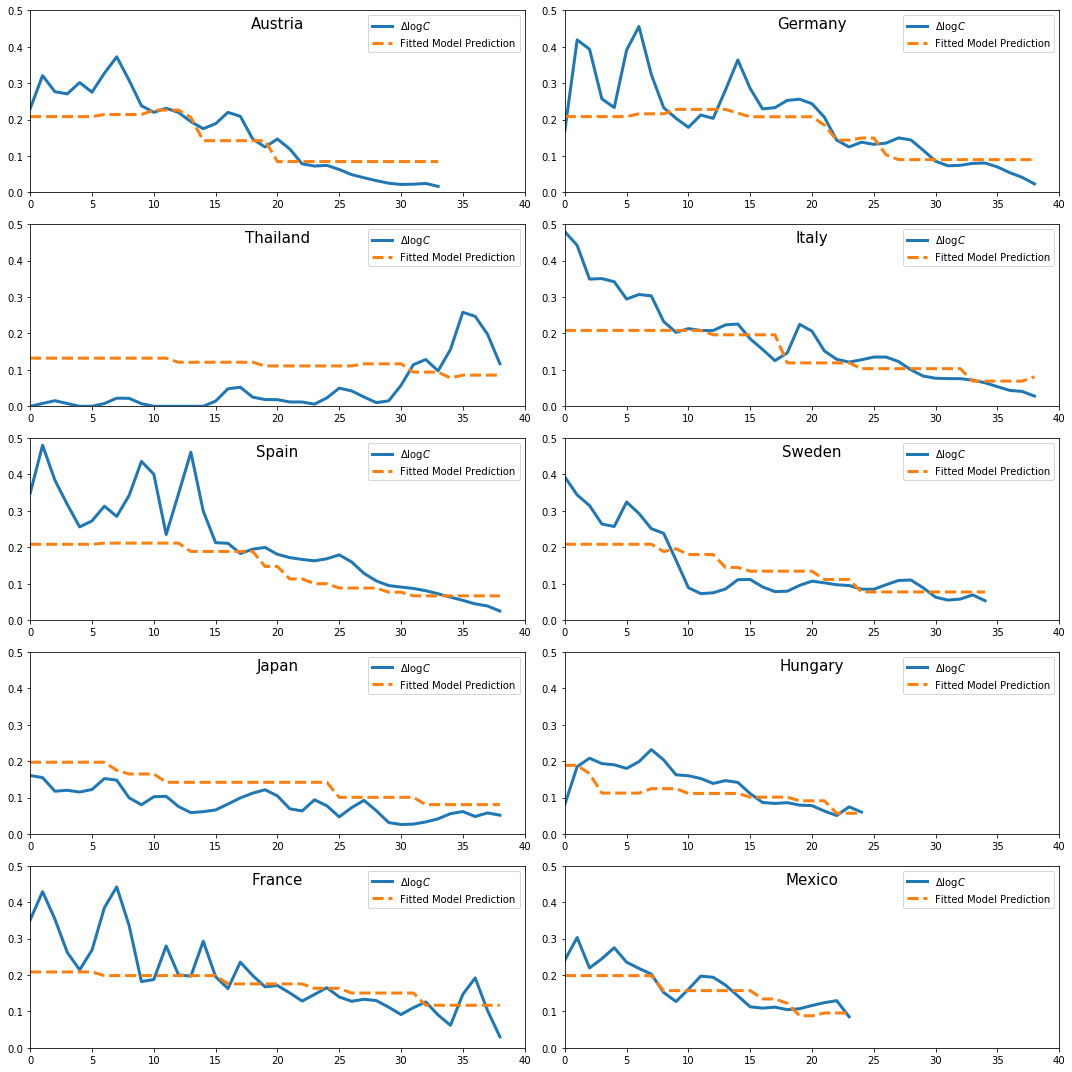

In [151]:
specialcountries = ['Austria','Germany','Thailand', 'Italy', 'Spain', 'Sweden',
                    'Japan', 'Hungary', 'France','Mexico']

cm = GetCountryMasks(regrDF[9])

plotxcount = int(len(specialcountries)/2) + len(specialcountries)%2

fig,ax = plt.subplots(plotxcount,2,figsize = (15,3*plotxcount))
ax = ax.flatten()

for i,country in enumerate(specialcountries):
    dlc = np.array(regrDF[9][cm[country]]['Observable'])
    pred = results_final9.predict()[cm[country]]
    ax[i].plot(dlc, lw = 3, c = 'TAB:BLUE', label = r'$\Delta \log C$')
    ax[i].plot(pred, lw = 3, c = 'TAB:ORANGE', linestyle = '--', label = 'Fitted Model Prediction')
    ax[i].set_ylim([0,.5])
    ax[i].set_xlim([0,40])
    ax[i].annotate(country, [20,.45],ha = 'center',fontsize = 15)
    ax[i].legend()
fig.tight_layout()
plt.savefig('regression_trajectories.pdf')


In [ ]:
import pickle

pickle.dump(regrDF, open('pickle/regrDF.pickle'))
pickle.dump(regrDF_test, open('pickle/regrDF_test.pickle'))
pickle.dump(regrDF_train, open('pickle/regrDF_test.pickle'))
pickle.dump(model_excludeC, open('pickle/model_excludeC.pickle'))
pickle.dump(model_singleC, open('pickle/model_singleC.pickle'))
pickle.dump(re)